### This is a demo for dem generation by using aster stereo images.
#### We use asp tool to perform dem generation. and we will compare the dem generation through: 
##### 1) running stereo with original images and 2) with mapprojected images (Auxiliary low-resolution dem data is required)



In [1]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from utils.imgShow import imgShow
from utils.get_dem import get_dem


#### Parameters settings

In [42]:
output_res = 30  # m resolution for output DEM
map_res = 15     # m  resolution for orthorectified input stereo pair
tsrs = '+proj=utm +zone=44 +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection
utm_code = '32644'
dir_raw_aster = 'data/aster_data/wkunlun-2020/aster_raw_L1A/AST_L1A_00303142020052844_20220315030514_20359'
# dir_raw_aster = 'data/aster_data/demo/AST_L1A_00307312017190728_20200218153629_19952'
dir_out='data/aster_data/demo'



### **1. Running stereo with original images.**

### 1.1. Parse the l1a aster data

In [43]:
!aster2asp $dir_raw_aster -o $dir_out/run



	--> Setting number of processing threads to: 4
Writing: data/aster_data/demo/run-Band3N.xml
Writing: data/aster_data/demo/run-Band3B.xml
Writing: data/aster_data/demo/run-Band3N.tif
        -->: [*******************************************************] Complete!
Writing: data/aster_data/demo/run-Band3B.tif
        -->: [*******************************************************] Complete!


### 1.2. Generate point cloud data

In [93]:
!parallel_stereo -t aster --subpixel-mode 3 $dir_out/run-Band3N.tif \
                    $dir_out/run-Band3B.tif $dir_out/run-Band3N.xml \
                    $dir_out/run-Band3B.xml $dir_out/pc_out/run


Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2022-Mar-22 09:08:44 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: data/aster_data/demo/pc_out/run-log-stereo_pprc-03-22-0908-8416.txt
Using session: aster.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
Loading camera model: data/aster_data/demo/run-Band3B.tif data/aster_data/demo/run-Band3B.xml
Distance between camera centers in meters: 404492.
Using image files:  data/aster_data/demo/run-Band3N.tif, data/aster_data/demo/run-Band3B.tif
Using camera files: data/aster_data/demo/run-Band3N.xml, data/aster_data/demo/run-Band3B.xml
	--> Using cached normalized input images.
	--> Using cached masks.
	--> Using cached subsampled images.
Convergence angle percentiles (in degr

### 2.3. covert cloud point file to dem image

In [94]:
 ## 0.0002777(in degrees), 0.00013885 and 0.0000898 is about 31, 15 and 10 m/pixel
# !point2dem --tr 0.0002777 $dir_out/pc_out/run-PC.tif -o $dir_out/dem_out/run
!point2dem --tr 30 --t_srs '{tsrs}' --errorimage $dir_out/pc_out/run-PC.tif -o $dir_out/dem_out/run



	--> Setting number of processing threads to: 4
Writing log info to: data/aster_data/demo/dem_out/run-log-point2dem-03-22-0931-10412.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Automatic triangulation error cutoff is 63.6586 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2384,2333) px.
Writing: data/aster_data/demo/dem_out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.495653
Writing: data/aster_data/demo/dem_out/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!


#### Reprojection (to wgs84) for the aster stereo image. !the aster image with wgs84 also provides extent for dem downloading.

In [50]:
# re-projected the l1a VNIR bands (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --t_srs "+proj=longlat +datum=WGS84" WGS84 $dir_out/run-Band3N.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band3N_wgs84.tif
!mapproject -t rpc --t_srs "+proj=longlat +datum=WGS84" WGS84 $dir_out/run-Band3B.tif $dir_out/run-Band3B.xml $dir_out/VNIR-Band3B_wgs84.tif
!mapproject -t rpc --t_srs "+proj=longlat +datum=WGS84" WGS84 $dir_raw_aster/*VNIR_Band1*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band1_wgs84.tif
!mapproject -t rpc --t_srs "+proj=longlat +datum=WGS84" WGS84 $dir_raw_aster/*VNIR_Band2*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band2_wgs84.tif




mapproject_single --query-projection WGS84 data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml data/aster_data/demo/VNIR-Band3N_wgs84.tif -t rpc --t_srs +proj=longlat +datum=WGS84
	--> Setting number of processing threads to: 4
Using session: rpc.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
	--> Using flat datum "WGS84" as elevation model.
Output pixel size: 0.000151656
Projected space bounding box: (Origin: (80.4608, 35.4933) width: 0.833195 height: 0.649996)
Image box: (Origin: (0, 0) width: 5495 height: 4287)
Output image size:
(width: 5495 height: 4287)
Query finished, exiting mapproject tool.

Output image size is 5495 by 4287 pixels.
Splitting into 2 by 1 tiles.
parallel --will-cite --workdir /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/Glacier-in-RGI1305 -u --env PATH --env PYTHONPATH --env ISISROOT --env ISISDATA -a data/aster_data/demo/VNIR-Band3N_wgs84_tif_tiles/argumentList.txt -P 2 --colsep \t

In [95]:
path_aster_wgs84 = dir_out + '/VNIR-Band3N_wgs84.tif'
aster_wgs84, aster_wgs84_info = readTiff(path_aster_wgs84); print('aster_wgs84:',aster_wgs84_info)
path_dem_aster = 'data/aster_data/demo/dem_out/run-DEM.tif'
dem_aster, dem_aster_info = readTiff(path_dem_aster); print('dem_aster:', dem_aster_info)



aster_wgs84: {'geoextent': (80.4607604740304, 81.29410755814752, 35.49323049065424, 36.14337770623388), 'geotrans': (80.4607604740304, 0.00015165552031248808, 0.0, 36.14337770623388, 0.0, -0.00015165552031248808), 'geosrs': '4326', 'row': 4287, 'col': 5495, 'bands': 1}
dem_aster: {'geoextent': (452355.0, 523875.0, 3928665.0, 3998655.0), 'geotrans': (452355.0, 30.0, 0.0, 3998655.0, 0.0, -30.0), 'geosrs': '32644', 'row': 2333, 'col': 2384, 'bands': 1}


In [53]:
### layer stacking for VNIR bands.
Band1 = dir_out + '/VNIR-Band1_wgs84.tif'
Band2 = dir_out + '/VNIR-Band2_wgs84.tif' 
Band3N = dir_out + '/VNIR-Band3N_wgs84.tif' 
path_laysta_wgs84 = dir_out + '/VNIR_LayStack_wgs84.tif'
lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laysta_wgs84)


In [54]:
path_laysta_utm = dir_out + '/VNIR_LayStack_utm.tif'
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:$utm_code  -tr 30 30 -r cubic -co COMPRESS=LZW -co TILED=YES $path_laysta_wgs84 $path_laysta_utm



Creating output file that is 2519P x 2408L.
Processing data/aster_data/demo/VNIR_LayStack_wgs84.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


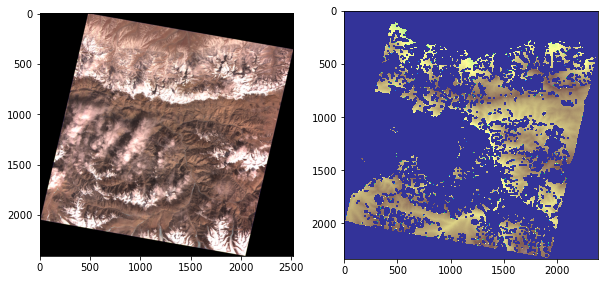

In [96]:
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=5)
plt.subplot(1,2,2); 
plt.imshow(dem_aster, vmin=0, vmax=8000, cmap='terrain')



### **2. Running stereo with mapprojected images.**

### 2.1. Get the srtm dem data of the region

In [68]:
aster_vnir, aster_vnir_info = readTiff(path_laysta_wgs84)
aoi_extent = aster_vnir_info['geoextent']
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
get_dem('SRTMGL1_E', aoi_extent, '7f97d1b49489d7c0e346b085772aef3c', path_out=path_srtm_wgs84)



https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=80.4607604740304&east=81.29410755814752&south=35.49323049065424&north=36.14337770623388&outputFormat=GTiff&API_Key=7f97d1b49489d7c0e346b085772aef3c
DEM data have been downloaded!


##### Reprojection for the srtm dem data

In [69]:
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'
!gdalwarp -overwrite -s_srs EPSG:4326 -t_srs EPSG:$utm_code  -tr 30 30 -r cubic -co COMPRESS=LZW -co TILED=YES $path_srtm_wgs84 $path_srtm_utm



Creating output file that is 2520P x 2408L.
Processing data/aster_data/demo/srtm_dem_wgs84.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/aster_data/demo/srtm_dem_wgs84.tif.
Copying nodata values from source data/aster_data/demo/srtm_dem_wgs84.tif to destination data/aster_data/demo/srtm_dem_utm.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


{'geoextent': (451084.3448432967, 526684.3448432967, 3927756.49205745, 3999996.49205745), 'geotrans': (451084.3448432967, 30.0, 0.0, 3999996.49205745, 0.0, -30.0), 'geosrs': '32644', 'row': 2408, 'col': 2520, 'bands': 1}


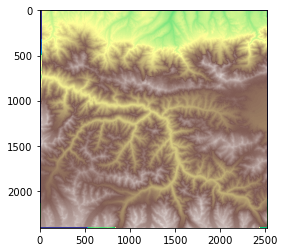

In [97]:
srtm_utm, srtm_utm_info = readTiff(path_srtm_utm)
print(srtm_utm_info)
plt.imshow(srtm_utm,vmin=0, vmax=7000, cmap='terrain')


In [71]:
# re-projected the l1a VNIR bands (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --tr 15 --t_srs '{tsrs}' $path_srtm_utm $dir_out/run-Band3N.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band3N_utm.tif
!mapproject -t rpc --tr 15 --t_srs '{tsrs}' $path_srtm_utm $dir_out/run-Band3B.tif $dir_out/run-Band3B.xml $dir_out/VNIR-Band3B_utm.tif
!mapproject -t rpc --tr 15 --t_srs '{tsrs}' $path_srtm_utm $dir_raw_aster/*VNIR_Band1*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band1_utm.tif
!mapproject -t rpc --tr 15 --t_srs '{tsrs}' $path_srtm_utm $dir_raw_aster/*VNIR_Band2*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band2_utm.tif


mapproject_single --query-projection data/aster_data/demo/srtm_dem_utm.tif data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml data/aster_data/demo/VNIR-Band3N_utm.tif -t rpc --tr 15 --t_srs +proj=utm +zone=44 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
	--> Setting number of processing threads to: 4
Using session: rpc.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
Output pixel size: 15
Projected space bounding box: (Origin: (451710, 3.92776e+06) width: 74760 height: 72090)
Image box: (Origin: (0, 0) width: 4985 height: 4807)
Output image size:
(width: 4985 height: 4807)
Query finished, exiting mapproject tool.

Output image size is 4985 by 4807 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/Glacier-in-RGI1305 -u --env PATH --env PYTHONPATH --env ISISROOT --env ISISDATA -a data/aster_data/demo/VNIR-Band3N_utm_tif_tiles/argumentList.txt -P 1 -

In [98]:
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'
!parallel_stereo -t astermaprpc --skip-rough-homography --subpixel-mode 3 \
                      $dir_out/VNIR-Band3N_utm.tif $dir_out/VNIR-Band3B_utm.tif \
                      $dir_out/run-Band3N.xml $dir_out/run-Band3B.xml \
                      $dir_out/pc_utm_out/run $path_srtm_utm


Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2022-Mar-22 09:40:02 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: data/aster_data/demo/pc_utm_out/run-log-stereo_pprc-03-22-0940-10634.txt
Using session: astermaprpc.
Loading camera model: data/aster_data/demo/VNIR-Band3N_utm.tif data/aster_data/demo/run-Band3N.xml
Loading camera model: data/aster_data/demo/VNIR-Band3B_utm.tif data/aster_data/demo/run-Band3B.xml
Distance between camera centers in meters: 404492.
Using image files:  data/aster_data/demo/VNIR-Band3N_utm.tif, data/aster_data/demo/VNIR-Band3B_utm.tif
Using camera files: data/aster_data/demo/run-Band3N.xml, data/aster_data/demo/run-Band3B.xml
Using input DEM: data/aster_data/demo/srtm_dem_utm.tif
	--> Using cached normalized input images.
	--> Using cac

In [99]:
# !point2dem --tr 0.000277777777778 --errorimage $dir_out/pc_wgs84_out/run-PC.tif -o $dir_out/dem_wgs84_out/run
!point2dem --tr 30 --t_srs '{tsrs}' --errorimage $dir_out/pc_utm_out/run-PC.tif -o $dir_out/dem_utm_out/run



	--> Setting number of processing threads to: 4
Writing log info to: data/aster_data/demo/dem_utm_out/run-log-point2dem-03-22-0958-12533.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Automatic triangulation error cutoff is 59.0507 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2404,2354) px.
Writing: data/aster_data/demo/dem_utm_out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.615451
Writing: data/aster_data/demo/dem_utm_out/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!


In [87]:
# ### layer stacking for VNIR bands.
# Band1 = dir_out + '/VNIR-Band1_utm.tif'
# Band2 = dir_out + '/VNIR-Band2_utm.tif' 
# Band3N = dir_out + '/VNIR-Band3N_utm.tif' 
# path_laystack = dir_out + '/VNIR_LayStack_utm.tif'
# lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laystack)

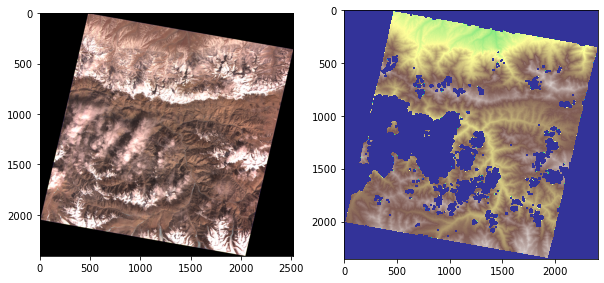

In [100]:
path_laysta_utm = dir_out + '/VNIR_LayStack_utm.tif'
path_dem_aster_utm = dir_out + '/dem_utm_out/run-DEM.tif'
dem_aster_utm, dem_aster_utm_info = readTiff(path_dem_aster_utm)
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=5)
plt.subplot(1,2,2); 
plt.imshow(dem_aster_utm, vmin=0, vmax=7000, cmap='terrain')


In [135]:
path_dems = dir_out + '/dems_utm.tif'
lay_stack(path_imgs=[path_srtm_utm, path_dem_aster_utm], path_out=path_dems)
dems_utm, dems_utm_info = readTiff(path_dems)
dems_dif = dems_utm[:,:,0]-dems_utm[:,:,1]


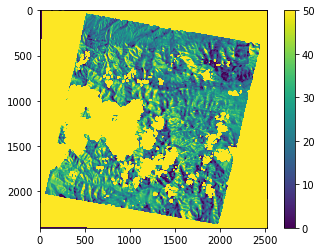

In [136]:
plt.imshow(dems_dif, vmin=0, vmax=50)
plt.colorbar()
